# **Import packages**

In [133]:
# !pip install python-box
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import random
from string import ascii_lowercase

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as weight_init

from box import Box

from My_code import Useful as uf

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

# **Data Set**

In [135]:
##### Loan dataset
df = pd.read_csv('../DAT/Second/loan_cond.csv')

In [136]:
##### user information dataset - Apply OneHot encoding to Gender
user_info = pd.read_csv('../DAT/Second/user_info(final).csv')
user_info = pd.concat([user_info.drop(columns = ["gender"]), pd.get_dummies(user_info['gender'])], axis = 1)

In [137]:
##### book(item) information dataset
book_info = pd.read_csv('../DAT/Second/book_info(final).csv')

### 파생변수1: 도서별 대출 횟수 변수 생성
book_cnt = pd.DataFrame([df["book_key"].value_counts().index, df["book_key"].value_counts()], index = ["book_key", "cnt"]).T
# book_cnt.head(3)

### 파생변수2: 발행국가 변수 생성
book_info["isbn13"] = book_info["isbn13"].fillna("666666666")
book_info["nation"] = book_info['isbn13'].str.slice(start = 3, stop = 5).astype(int)

nation_100 = book_info["nation"].value_counts()[book_info["nation"].value_counts() < 100].index
book_info["nation"] = np.select([book_info["nation"].isin(nation_100)], [9999], book_info["nation"])

### kdc 200회 미만 kdc etc로 변환
kdc_200 = book_info.kdc.value_counts()[book_info.kdc.value_counts() < 200].index
book_info["kdc"] = np.select([book_info["kdc"].isin(kdc_200)], ["kdc etc"], book_info["kdc"])

In [140]:
### 사용할 변수만 추출 및 Apply OneHot encoding to kdc and nation
book_info = book_info[["book_key", "publish_year", "kdc", "nation"]]
book_info = pd.concat([book_info.drop(columns = ["kdc"]), pd.get_dummies(book_info['kdc'], prefix = "kdc_")], axis = 1)
book_info = pd.concat([book_info.drop(columns = ["nation"]), pd.get_dummies(book_info['nation'], prefix = "nation_")], axis = 1)
book_info = pd.merge(book_info, book_cnt, how = "left", on = "book_key").fillna(0)

uf.multi_table([user_info.head(3), book_info.head(3)])

# **학습 기본 설정**

In [141]:
config = {
    'data_path' : "../DAT/Second" , # 데이터 경로
    'p_dims': [400, 600],
    'dropout_rate' : 0.5,
    'weight_decay' : 0.01,
    
    'valid_samples' : 5,
    
    'seed' : 717,
    'anneal_cap' : 0.2,
    'total_anneal_steps' : 200000,
    'lr' : 0.005,
    'batch_size' : 500,
    'num_epochs' : 100,
    'num_workers' : 2,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Box(config)

In [142]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(config.seed) # Seed 고정

# **데이터 전처리**

## **_MakeMatrixDataSet**

In [143]:
class MakeMatrixDataSet() :
    
    """ MatrixDataSet 생성 """
    def __init__(self, config):
        self.config = config
        
        
        # 대여(평점) 데이터
#         self.df = pd.read_csv(os.path.join(self.config.data_path, 'loan_cond(last).csv'))
        self.df = df

        # 부가 정보 데이터
        self.user_info = user_info
        self.book_info = book_info
        
        # 대여 데이터에 있는 부가 정보만 추출
        self.user_info = self.user_info[self.user_info["user_key"].isin(self.df["user_key"])].reset_index(drop = True)
        self.book_info = self.book_info[self.book_info["book_key"].isin(self.df["book_key"])].reset_index(drop = True)
    
    
        # User key, Book key를 일련된 번호로 저장(user_idx, book_idx)
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder('book_key')
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder('user_key')
        
        self.df['book_idx'] = self.df['book_key'].apply(lambda x : self.item_encoder[x])
        self.df['user_idx'] = self.df['user_key'].apply(lambda x : self.user_encoder[x])
        
        self.user_info['user_idx'] = self.user_info['user_key'].apply(lambda x : self.user_encoder[x])
        self.book_info['book_idx'] = self.book_info['book_key'].apply(lambda x : self.item_encoder[x])

        
        # User와 Book의 고유 개수
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        # Train and Valid split
        self.user_train, self.user_valid = self.generate_sequence_data()

        
        
    """  encoder, decoder 생성 """
    def generate_encoder_decoder(self, col : str) -> dict:
        
        encoder = {}
        decoder = {}
        ids = self.df[col].unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    
    
    """ sequence_data 생성 : Train data 와 Valid(test) data """
    def generate_sequence_data(self) -> dict:
        
        users = defaultdict(list)
        user_train = {}
        user_valid = {}
        for user, item, time in zip(self.df['user_idx'], self.df['book_idx'], self.df['loan_date']):
            users[user].append(item)
        
        for user in users:
            np.random.seed(self.config.seed)

            user_total = users[user]
            if len(user_total) > self.config.valid_samples :
                valid = np.random.choice(user_total, size = self.config.valid_samples, replace = False).tolist()
            else :
                valid = []
            train = list(set(user_total) - set(valid))

            user_train[user] = train
            user_valid[user] = valid # valid_samples 개수 만큼 검증에 활용 (현재 Task와 가장 유사하게)

        return user_train, user_valid
    
    
    def get_train_valid_data(self):
        return self.user_train, self.user_valid
    

    
    """ User x Book 행렬 생성 : user_item_dict를 바탕으로 행렬 생성 """
    def make_matrix(self, user_list, train = True):
        
        mat = torch.zeros(size = (user_list.size(0), self.num_item))
        for idx, user in enumerate(user_list):
            if train:
                mat[idx, self.user_train[user.item()]] = 1
            else:
                mat[idx, self.user_train[user.item()] + self.user_valid[user.item()]] = 1
                
                
        return mat
    
    
    
    """ User Information dataset 생성 """
    def make_user_info(self, user_list) : 
        UI = self.user_info[self.user_info["user_idx"].isin(user_list)].drop(columns = ["user_key", "user_idx"])
        UI["birth_year"] = UI["birth_year"].astype(int)
        UI = torch.tensor([UI.values])
        
        return UI
    
    
    
    """ Book Information dataset 생성 """
    def make_book_info(self) : 
        BI = self.book_info.drop(columns = ["book_key","book_idx"]).T
        BI = torch.tensor([BI.values])
        
        return BI

## **_AEDataSet**

In [144]:
class AEDataSet(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user
        self.users = [i for i in range(num_user)]

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx): 
        user = self.users[idx]
        return torch.LongTensor([user])

# **모델 AI-VAE**

AI-VAE : Auxiliary Information - VAE

In [ ]:
def swish(x):
    return x.mul(torch.sigmoid(x))


def norm_(x):
    mu = torch.mean(x, dim = 1)
    sigma = (x-mu[:, None]).pow(2).sum(dim = 1).sqrt() + (1e-6)
#     sigma = torch.std(x, dim = 1) + (1e-6)
    norm_x = (x-mu[:, None]) / sigma[:, None]
    
    return norm_x

""" Auxiliary Information 결합 MLP """
### 사용자와 도서 정보의 교호효과 신경망
class InfoMLP(nn.Module):
    def __init__(self, UI_num,  BI_num, drop_prob = 0.2, hidden_dim = 600):
        super(InfoMLP, self).__init__()
        self.dropout = nn.Dropout(p = drop_prob)
        
        self.linear_ui1 = nn.Linear(UI_num, hidden_dim)
        self.linear_ui2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui5 = nn.Linear(hidden_dim, hidden_dim)
        
        self.linear_bi1 = nn.Linear(BI_num, hidden_dim)
        self.linear_bi2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi5 = nn.Linear(hidden_dim, hidden_dim)

        self.ln1 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln2 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln3 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln4 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln5 = nn.LayerNorm(hidden_dim, eps = 1e-1)
               
            
    def forward(self, UI, BI):
               
        UI = self.dropout(F.normalize(UI.float()))

        mlp_ui1 = self.ln1(swish(self.linear_ui1(UI)))
        mlp_ui2 = self.ln2(swish(self.linear_ui2(mlp_ui1) + mlp_ui1))
        mlp_ui3 = self.ln3(swish(self.linear_ui3(mlp_ui2) + mlp_ui2 + mlp_ui1))
        mlp_ui4 = self.ln4(swish(self.linear_ui4(mlp_ui3) + mlp_ui3 + mlp_ui2 + mlp_ui1))
        mlp_ui5 = self.ln5(swish(self.linear_ui5(mlp_ui4) + mlp_ui4 + mlp_ui3 + mlp_ui2 + mlp_ui1))
        ui_output = mlp_ui5
               
        BI = self.dropout(F.normalize(BI.float()))

        mlp_bi1 = self.ln1(swish(self.linear_bi1(BI)))
        mlp_bi2 = self.ln2(swish(self.linear_bi2(mlp_bi1) + mlp_bi1))
        mlp_bi3 = self.ln3(swish(self.linear_bi3(mlp_bi2) + mlp_bi2 + mlp_bi1))
        mlp_bi4 = self.ln4(swish(self.linear_bi4(mlp_bi3) + mlp_bi3 + mlp_bi2 + mlp_bi1))
        mlp_bi5 = self.ln5(swish(self.linear_bi5(mlp_bi4) + mlp_bi4 + mlp_bi3 + mlp_bi2 + mlp_bi1))
        bi_output = mlp_bi5
        
        return ui_output.matmul(bi_output.T)
    

### 사용자 정보 신경망
class UIMLP(nn.Module):
    def __init__(self, UI_num, bi_num, drop_prob = 0.2, hidden_dim = 600):
        super(UIMLP, self).__init__()
        self.dropout = nn.Dropout(p = drop_prob)
        
        self.linear_ui1 = nn.Linear(UI_num, hidden_dim)
        self.linear_ui2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_ui5 = nn.Linear(hidden_dim, bi_num)
        

        self.ln1 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln2 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln3 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln4 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln5 = nn.LayerNorm(bi_num, eps = 1e-1)
               
            
    def forward(self, UI):
               
        UI = self.dropout(F.normalize(UI.float()))

        mlp_ui1 = self.ln1(swish(self.linear_ui1(UI)))
        mlp_ui2 = self.ln2(swish(self.linear_ui2(mlp_ui1) + mlp_ui1))
        mlp_ui3 = self.ln3(swish(self.linear_ui3(mlp_ui2) + mlp_ui2 + mlp_ui1))
        mlp_ui4 = self.ln4(swish(self.linear_ui4(mlp_ui3) + mlp_ui3 + mlp_ui2 + mlp_ui1))
        mlp_ui5 = self.ln5(swish(self.linear_ui5(mlp_ui4)))
        ui_output = mlp_ui5

        
        return ui_output
    
    
### 도서 정보 신경망
class BIMLP(nn.Module):
    def __init__(self, BI_num, ui_num, drop_prob = 0.2, hidden_dim = 600):
        super(BIMLP, self).__init__()
        self.dropout = nn.Dropout(p = drop_prob)
        
        self.linear_bi1 = nn.Linear(BI_num, hidden_dim)
        self.linear_bi2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi4 = nn.Linear(hidden_dim, hidden_dim)
        self.linear_bi5 = nn.Linear(hidden_dim, ui_num)

        self.ln1 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln2 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln3 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln4 = nn.LayerNorm(hidden_dim, eps = 1e-1)
        self.ln5 = nn.LayerNorm(ui_num, eps = 1e-1)
               
            
    def forward(self, BI):
               
        BI = self.dropout(F.normalize(BI.float()))

        mlp_bi1 = self.ln1(swish(self.linear_bi1(BI)))
        mlp_bi2 = self.ln2(swish(self.linear_bi2(mlp_bi1) + mlp_bi1))
        mlp_bi3 = self.ln3(swish(self.linear_bi3(mlp_bi2) + mlp_bi2 + mlp_bi1))
        mlp_bi4 = self.ln4(swish(self.linear_bi4(mlp_bi3) + mlp_bi3 + mlp_bi2 + mlp_bi1))
        mlp_bi5 = self.ln5(swish(self.linear_bi5(mlp_bi4)))
        bi_output = mlp_bi5
        
        return bi_output.T


In [145]:
""" AI-VAE """
class AIVAE_UB(nn.Module):

    def __init__(self, p_dims, UI_num, BI_num, item_num, dropout_rate = 0.5):
        super(AIVAE_UB, self).__init__()
        
        self.InfoMLP = InfoMLP(UI_num = UI_num, BI_num = BI_num, drop_prob = 0.5)
        self.UIMLP = UIMLP(UI_num = UI_num, bi_num = 11475, drop_prob = 0.5)
        self.BIMLP = BIMLP(BI_num = BI_num, ui_num = 500, drop_prob = 0.5)
        self.item_num = item_num
        
        # 입 출력 Layer
        self.p_dims = p_dims   
        self.q_dims = p_dims[::-1]
        
        
        # Input Layer
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])

        # AI - Input Layer
        temp_i_dims = self.q_dims
        self.i_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_i_dims[:-1], temp_i_dims[1:])])       
        
        # Output Layer
        temp_p_dims = self.p_dims[:-2] + self.p_dims[-1]
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_p_dims[:-1], temp_p_dims[1:])])

        # ETC
        self.ln1 = nn.LayerNorm(lay , eps = 1e-1)
        self.ln2 = nn.LayerNorm(lay , eps = 1e-1)
        
        self.drop = nn.Dropout(dropout_rate)
        self.init_weights()
        
        
    
    def forward(self, input, info_u, info_b, loss = False):
       
        # 대여 데이터 VAE encoder를 통해 잠재변수(z) 생성
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)

        
        # 사용자, 도서 정보 데이터 신경망         
        info_u = info_u.to(dtype=torch.float32)[0]
        info_b = info_b.to(dtype=torch.float32)[0]
        
        info_mat = self.InfoMLP(UI = info_u, BI = info_b.T)
        ui_mat = self.UIMLP(UI = info_u)
        bi_mat = self.BIMLP(BI = info_b.T)
        
        # 신경망을 통과한 부가 정보 데이터에 VAE encoder 적용해 잠재변수 형태로 변환
        z_info = self.encode_i(info_mat)
        z_ui = self.encode_i(ui_mat)
        z_bi = self.encode_i(bi_mat)
        
        
        # 부가 정보의 잠재변수를 z와 동일한 분산을 갖도록 변환
        norm_z_info = norm_(z_info)
        z_info_norm = (norm_z_info).mul(torch.exp(0.5 * logvar))    
        
        norm_z_ui = norm_(z_ui)
        z_ui_norm = (norm_z_ui).mul(torch.exp(0.5 * logvar))    
        
        norm_z_bi = norm_(z_bi)
        z_bi_norm = (norm_z_bi).mul(torch.exp(0.5 * logvar))    
    
        
        # 각 잠재변수를 동일한 가중치로 결합 및 신경망 통과
        z_comb = self.ln1((z + z_info_norm + z_ui_norm + z_bi_norm))
        z_comb_ = self.ln2(z_comb)
    
    
        # 결합된 잠재변수에 VAE decoder 적용
        h = self.decode(z_comb_)
   
        if loss:
            return h, mu, logvar
        else:
            return h
    
    
    # 대여 데이터의 VAE encoder
    def encode(self, input):
        h = F.normalize(input)        
        h = self.drop(h)

        for i, layer in enumerate(self.q_layers):
            h = layer(h)

            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
                
        return mu, logvar
    
    # 정보 데이터의 VAE encoder
    def encode_i(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.i_layers):
            h = layer(h)
            h = F.tanh(h)
#             if i != len(self.i_layers) - 1:
#                 h = F.tanh(h)
            

        return h
    

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.sigmoid(h)
        return h
    

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
            
        for layer in self.i_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
            

# **학습 함수**

In [146]:
class LossFunc(nn.Module):

    def __init__(self, loss_type = 'Multinomial'):
        super(LossFunc, self).__init__()
        self.loss_type = loss_type

    def forward(self, recon_x = None, x = None, mu = None, logvar = None):
        if self.loss_type == 'Gaussian':
            loss = self.Gaussian(recon_x, x)
        elif self.loss_type == 'Logistic':
            loss = self.Logistic(recon_x, x)
        elif self.loss_type == 'Multinomial':
            loss = self.Multinomial(recon_x, x)

        KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        loss = loss + KLD

        return loss

    def Gaussian(self, recon_x, x):
        gaussian = F.mse_loss(recon_x, x)
        return gaussian

    def Logistic(self, recon_x, x):
        logistic = F.binary_cross_entropy(recon_x.sigmoid(), x, reduction='none').sum(1).mean()
        return logistic

    def Multinomial(self, recon_x, x):
        multinomial = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
        return multinomial

In [147]:
def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(1, len(pred_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg


def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    if len(true_list) == 0 :
        hit = 0
    else :
        hit = len(hit_list) / len(true_list)
        
    return hit



def train(model, criterion, optimizer, data_loader, make_matrix_data_set, config):
    global update_count
    model.train()
    loss_val = 0
    
    BI = make_matrix_data_set.make_book_info()
    BI = BI.to(device)
    
    for users in data_loader:
        mat = make_matrix_data_set.make_matrix(users)
        mat = mat.to(device)
        UI = make_matrix_data_set.make_user_info(users)
        UI = UI.to(device)

        
        recon_mat, mu, logvar = model(input = mat, info_u = UI, info_b = BI, loss = True)

        optimizer.zero_grad()

        loss = criterion(recon_x = recon_mat, x = mat, mu = mu, logvar = logvar)
        loss_val += loss.item()
        loss.backward()
        
        optimizer.step()

    loss_val /= len(data_loader)

    return loss_val


def evaluate(model, data_loader, user_train, user_valid, make_matrix_data_set):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10
    cnt = 0.0

    with torch.no_grad():
        BI = make_matrix_data_set.make_book_info()
        BI = BI.to(device)
        for users in data_loader:
            mat = make_matrix_data_set.make_matrix(users)
            mat = mat.to(device)
            UI = make_matrix_data_set.make_user_info(users)
            UI = UI.to(device)

            recon_mat = model(mat, info_u = UI, info_b = BI)

            recon_mat[mat == 1] = -np.inf
            rec_list = recon_mat.argsort(dim = 1)

            for user, rec in zip(users, rec_list):
                uv = user_valid[user.item()]
                up = rec[-config.valid_samples:].cpu().numpy().tolist()
                NDCG += get_ndcg(pred_list = up, true_list = uv)
                HIT += get_hit(pred_list = up, true_list = uv)
                cnt += 1.0 if len(uv) == 0 else 0.0

    NDCG /= (len(data_loader.dataset) - cnt)
    HIT /= (len(data_loader.dataset) - cnt)

    return NDCG, HIT

# **학습**

In [148]:
make_matrix_data_set = MakeMatrixDataSet(config = config)
user_train, user_valid = make_matrix_data_set.get_train_valid_data()

In [149]:
ae_dataset = AEDataSet(num_user = make_matrix_data_set.num_user)

In [150]:
data_loader = DataLoader(ae_dataset,
                         batch_size = config.batch_size,    # batch size = 500
                         shuffle = True, 
                         pin_memory = True,
                         num_workers = config.num_workers,
                         drop_last = True
                         )

In [151]:
loss_dict, ndcg_dict, hit_dict = {}, {}, {}

In [152]:
model = AIVAE_UB(p_dims = config.p_dims + [make_matrix_data_set.num_item],
                 UI_num = make_matrix_data_set.user_info.drop(columns = ["user_key", "user_idx"]).shape[1],
                 BI_num = make_matrix_data_set.book_info.drop(columns = ["book_key", "book_idx"]).shape[1],
                 dropout_rate = config.dropout_rate,
                 item_num = make_matrix_data_set.num_item).to(device)


criterion = LossFunc(loss_type = 'Multinomial')
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)

In [153]:
best_hit = 0
update_count = 1
loss_list, ndcg_list, hit_list = [], [], []


for epoch in range(1, config.num_epochs + 1):
    
    train_loss = train( model = model, 
                        criterion = criterion, 
                        optimizer = optimizer, 
                        data_loader = data_loader,
                        make_matrix_data_set = make_matrix_data_set,
                        config = config )
    
    ndcg, hit = evaluate( model = model, 
                          data_loader = data_loader,
                          user_train = user_train,
                          user_valid = user_valid,
                          make_matrix_data_set = make_matrix_data_set )

    loss_list.append(train_loss)
    ndcg_list.append(ndcg)
    hit_list.append(hit)
    
    if (epoch == 1) | ((epoch) % 10 == 0) :
        print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')
#     break
torch.cuda.empty_cache() 

Epoch:   1| Train loss: 82.10497| NDCG@10: 0.00836| HIT@10: 0.00590
Epoch:  10| Train loss: 73.82907| NDCG@10: 0.09229| HIT@10: 0.06863
Epoch:  20| Train loss: 72.04410| NDCG@10: 0.09786| HIT@10: 0.07304
Epoch:  30| Train loss: 70.82808| NDCG@10: 0.10120| HIT@10: 0.07497
Epoch:  40| Train loss: 69.86041| NDCG@10: 0.09833| HIT@10: 0.07384
Epoch:  50| Train loss: 69.34106| NDCG@10: 0.10007| HIT@10: 0.07475
Epoch:  60| Train loss: 68.77174| NDCG@10: 0.10112| HIT@10: 0.07474
Epoch:  70| Train loss: 68.36994| NDCG@10: 0.10230| HIT@10: 0.07542
Epoch:  80| Train loss: 68.18470| NDCG@10: 0.09909| HIT@10: 0.07356
Epoch:  90| Train loss: 67.70367| NDCG@10: 0.10057| HIT@10: 0.07458
Epoch: 100| Train loss: 67.42754| NDCG@10: 0.10069| HIT@10: 0.07429


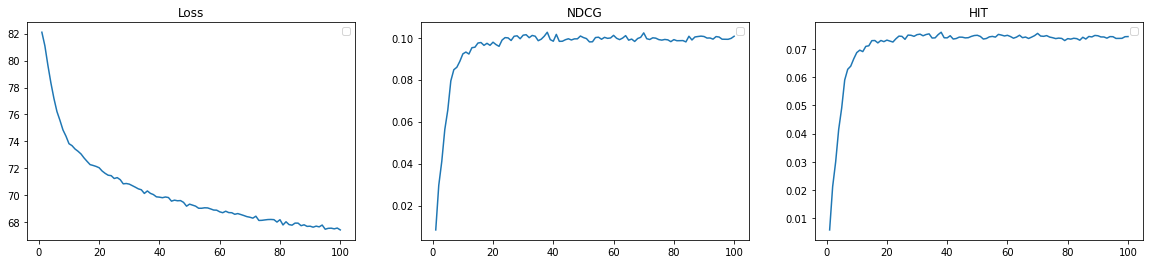

K =  5
Best NDCG : 0.1026  |  Best Hit : 0.0758


,loss,ndcg,hit
0,82.104971,0.008363,0.005900
1,81.097410,0.029624,0.021210
2,79.650201,0.041040,0.029988
3,78.337329,0.056203,0.041423
4,77.189887,0.065571,0.049036


In [157]:
fig, ax = plt.subplots(1, 3, figsize = (20, 4))
ax = ax.flatten()
epochs = [i for i in range(1, config.num_epochs + 1)]

# Loss plot
ax[0].plot(epochs, loss_list)
ax[0].set_title('Loss')
ax[0].legend()

# NDCG plot
ax[1].plot(epochs, ndcg_list)
ax[1].set_title('NDCG')
ax[1].legend()

# Hit plot
ax[2].plot(epochs, hit_list)
ax[2].set_title('HIT')
ax[2].legend()
plt.show()


# Loss, NDCG, Hit dataframe
print("=="*20)
print("K = ", config.valid_samples)
print("Best NDCG : %.4f  |  Best Hit : %.4f" % (max(ndcg_list), max(hit_list)))
print("=="*20)
result_df = pd.DataFrame([loss_list, ndcg_list, hit_list], index = ["loss", "ndcg", "hit"]).T
result_df.head()

# **결과 저장**

In [158]:
# result_df.to_csv("../OUT/Second/AI-VAE.csv", index = False)

In [159]:
# result_df.to_csv("../OUT/Second/AI-VAE(5).csv", index = False) 